<a href="https://colab.research.google.com/github/iguiliz/japcalculator/blob/master/projetML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Projet : Prédire si une eau est potable ou non.**
---



## **Importation des dépendances**

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# numpy arrays are used to .
import numpy as np

# pandas is used to manipulate tabular data.
import pandas as pd

# Matplotlib is used to plot graphs
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# Style options for plots.
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Importation des données
import os
import io
import tarfile
import urllib
from google.colab import files

# Traitement des valeurs manquantes
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

## For PCA part
#################
from sklearn.preprocessing import scale 
from sklearn import model_selection
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression, PLSSVD
from sklearn.metrics import mean_squared_error

# Some libraries for PCA visualization
import seaborn as sns 
sns.set_theme(palette="Set1")
#Make Plotly figure
#import chart_studio.plotly as py
# Be aware, plotly may be installed using pip on your shell:
# conda install -c plotly chart-studio
import plotly.graph_objs as go
from sklearn.metrics import accuracy_score


## **Importation du jeu de données**

On définit une première méthode pour importer nos données.


In [ ]:
DOWNLOAD_ROOT = "https://www.kaggle.com/artimule/drinking-water-probability/download"
EAU_PATH = os.path.join("datasets", "eau")
EAU_URL = DOWNLOAD_ROOT + "datasets/eau/eau.tgz"

def fetch_eau_data(eau_url=EAU_URL, eau_path=EAU_PATH):
    if not os.path.isdir(eau_path):
        os.makedirs(eau_path)
    tgz_path = os.path.join(eau_path, "eau.tgz")
    urllib.request.urlretrieve(eau_url, tgz_path)
    eau_tgz = tarfile.open(tgz_path)
    eau_tgz.extractall(path=eau_path)
    eau_tgz.close()


# Load data
csv_path = os.path.join(EAU_PATH, "eau.csv")
eau_df = pd.read_csv(csv_path, index_col = False)
eau_df.head()

FileNotFoundError: ignored

On définit une seconde méthode pour importer nos données.

In [ ]:
data_to_load = files.upload()
eau_df=pd.read_csv(io.BytesIO(data_to_load['drinking_water_potability.csv']))

Saving drinking_water_potability.csv to drinking_water_potability.csv


## **Analyse descriptive des données**
Dans cette partie, nous souhaitons acquérir une meilleure compréhension des données que nous allons utiliser. Nous recherchons toutes les informations susceptibles d'aiguiller le choix des méthodes et des modèles à implémenter pour résoudre le problème de classification.

### Analyse générale
Afin de débuter l'analyse, nous affichons simplement les premières lignes de notre dataset.



In [ ]:
eau_df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890456,20791.31898,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.05786,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.54173,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.41744,8.059332,356.886136,363.266516,18.436525,100.341674,4.628771,0
4,9.092223,181.101509,17978.98634,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


**Remarques:**
*   le jeu de données contient neuf variables numériques continues. Elles correspondent à neuf propriétés de l'eau liquide : son ph (**ph**), sa dureté (**Hardness**), la concentration totale des solides dissous (**Solids**), la concentration en chloramines (**Chloramines**), la concentration en sulfate (**Sulfate**), la conductivité (**Conductivity**), la quantité de carbone organique (**Organic_carbon**), la quantité de trihalométhanes (**Trihalomethanes**) et la teneur eau en particules suspendues (**Turbidity**).
*   le jeu de données contient une variable catégorielle, la variable cible **Potability** qui indique si une eau est potable (1) ou non potable (0).



Par la suite, nous décidons d'afficher les statistiques globales du jeu de données.

In [ ]:
eau_df.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000,3276.000000
mean,7.080795,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786,0.390110
std,1.594320,32.879761,8768.570828,1.583085,41.416840,80.824064,3.308162,16.175008,0.780382,0.487849
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.093092,176.850538,15666.690300,6.127421,307.699498,365.734414,12.065801,55.844536,3.439711,0.000000
50%,7.036752,196.967627,20927.833605,7.130299,333.073546,421.884968,14.218338,66.622485,3.955028,0.000000
75%,8.062066,216.667456,27332.762125,8.114887,359.950170,481.792305,16.557652,77.337473,4.500320,1.000000
max,14.000000,323.124000,61227.196010,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


Ce premier aperçu nous permet de récolter quelques informations sur nos données :
*   Le dataset contient 3276 observations.
*   Certaines variables contiennent des valeurs manquantes, c'est le cas de **ph**, **Sulfate** et **Trihalomethanes**. Une section de ce notebook est consacrée au traitement de ces valeurs.
*   Nous remarquons que la valeur de la médiane de **Solids** est 20 927, or nous savons que la valeur de **Solids** ne dois pas dépasser 1000 dans le cas d'une eau potable (cf. description Kaggle). Nous nous interrogeons donc sur la répartition des classes "potable" et "non potable" au sein du jeu de données.





### Analyse de la variable cible **Potability**
Nous continuons notre analyse avec l'étude de la répartition de la variable cible.

In [ ]:
repartition_variable_cible = eau_df["Potability"].value_counts()
taille = len(eau_df)
pourcentage_eau_non_potable = round(100*repartition_variable_cible[0]/taille)
pourcentage_eau_potable = round(100*repartition_variable_cible[1]/taille)
print("Il y a {0} eaux non potables, soit {1}% des données.".format(repartition_variable_cible[0], pourcentage_eau_non_potable))
print("Il y a {0} eaux potables, soit {1}% des données.".format(repartition_variable_cible[1], pourcentage_eau_potable))

Il y a 1998 eaux non potables, soit 61% des données.
Il y a 1278 eaux potables, soit 39% des données.


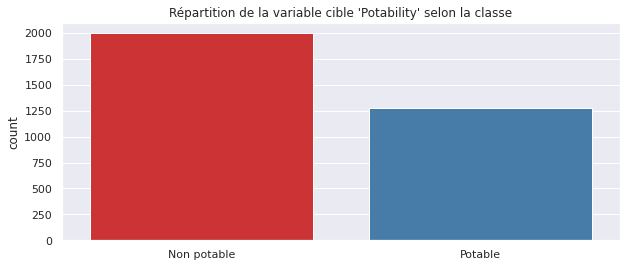

In [ ]:
plt.figure(figsize=(10,4))
ax = sns.countplot(data = eau_df, x="Potability", tick_label=["Potable", "Potdable"])
ax.set_xticklabels(["Non potable", "Potable"])
ax.set_xlabel(None)
plt.title("Répartition de la variable cible 'Potability' selon la classe")
plt.show()

**Observations**: 
<br> Le dataset contient davantage d'eaux non potables (1998 observations) que d'eaux potables (1278 observations). 

<br>Nous pouvons faire une hypothèse sur les performances du modèle que nous allons entraîner. Etant donné qu'il va rencontrer plus d'observations représentant des eaux non potable lors de son entraînement, il devrait mieux classifier les eaux non potables que les eaux potables. 

<br> Dans le cas de notre problème, une connaissance accrue des eaux non potables est préférable. En effet, les faux positifs doivent être absolument évités. Si l'on se place dans une situation réelle, si l'algorithme déclare qu'une eau impropre à la consommation est potable alors cela pourrait avoir des conséquences sanitaires importantes.

### Analyse des **features** : 
Nous poursuivons avec l'observation de la distribution de nos 9 variables ainsi que les corrélations qui existent, ou non, entre elles.

Text(0.5, 0.98, 'Graphiques des corrélations deux à deux des variables du jeu de données')

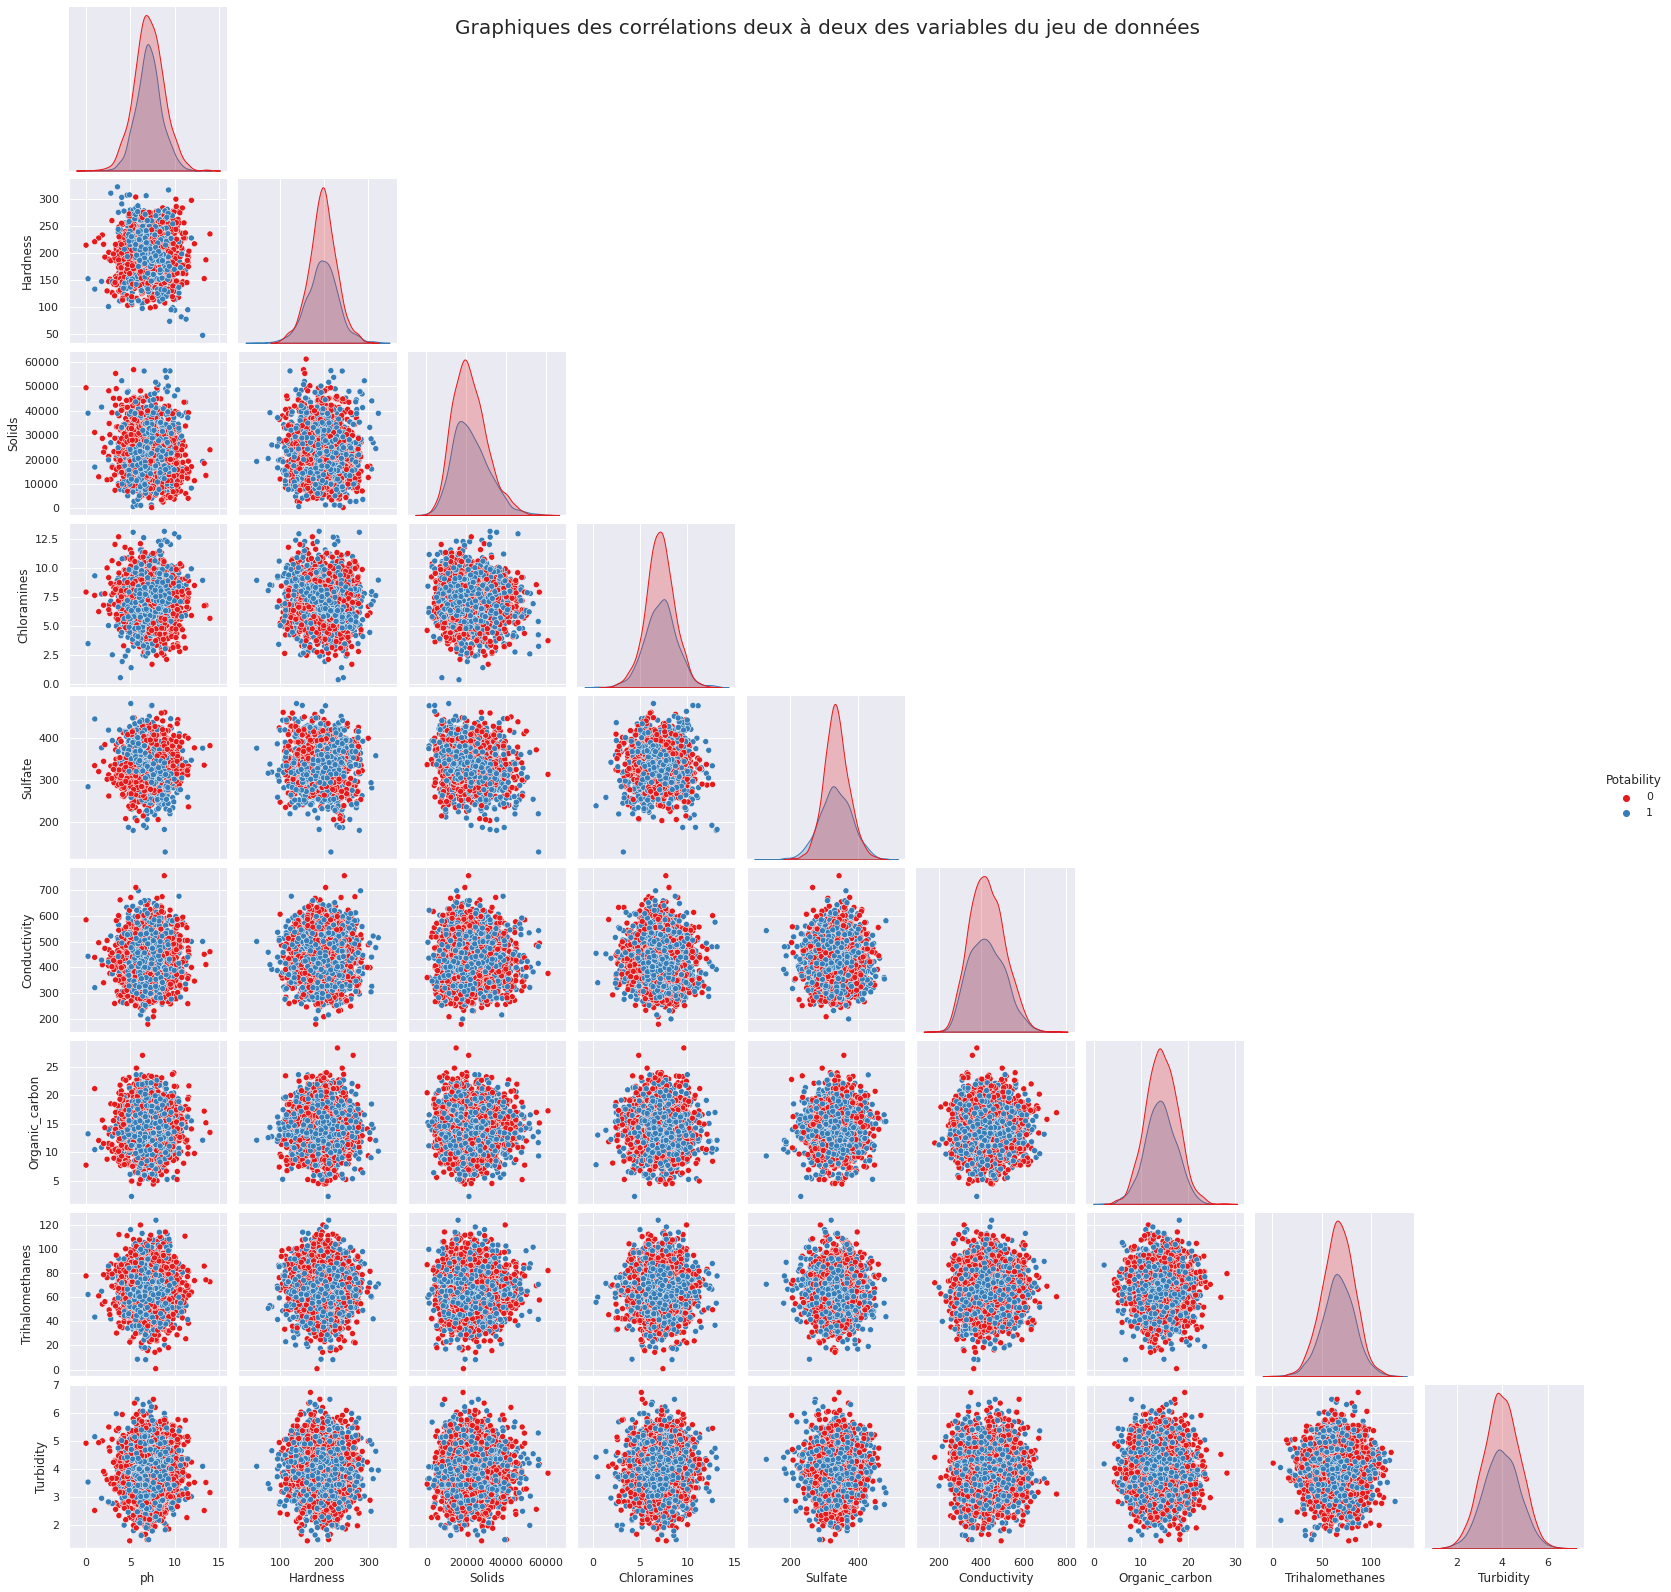

In [ ]:
my_pairplot=sns.pairplot(eau_df, hue="Potability", corner=True)
my_pairplot.figure.suptitle("Graphiques des corrélations deux à deux des variables du jeu de données", size=20)

**Observations:**
*   Il n'existe pas de corrélation visuellement observable au sein de données. Si corrélation il y a, sa valeur est extrêmement faible.
*   Dans un espace en 2 dimensions, il semble difficile de séparer les instances selon la classe.




### Analyse de la corrélation entre nos features et la variable cible:
Pour conclure l'analyse des données, nous étudions la corrélation entre notre variable cible **Potability** et les autresvariables. L'objectif est d'avoir une première intuition sur les variables qui seront importantes pour notre problème de classification.

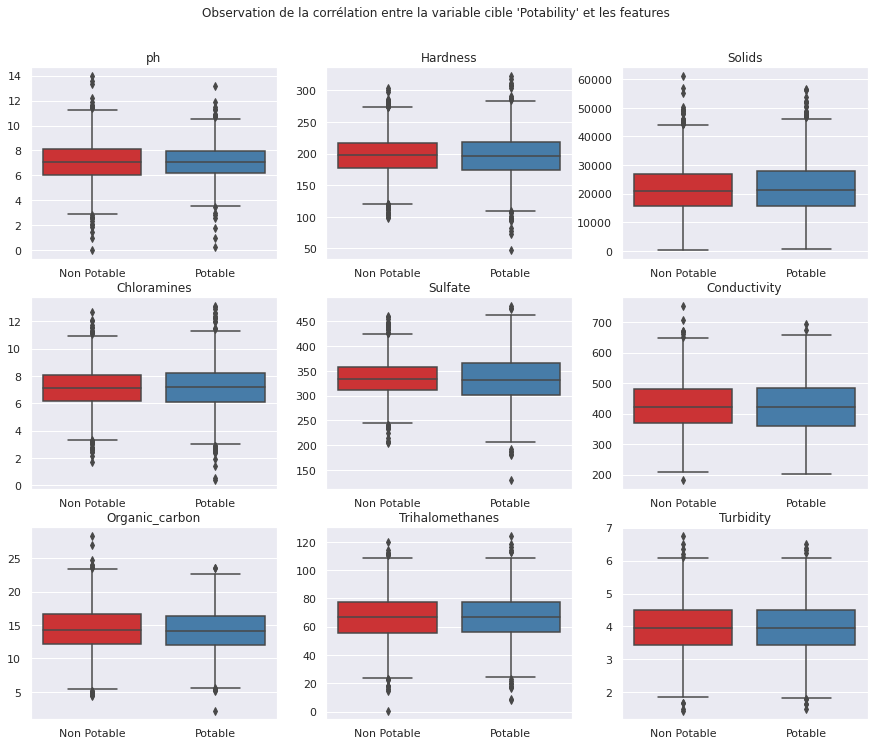

In [ ]:
fig, axes = plt.subplots(3,3, figsize = (15,12))
fig.suptitle("Observation de la corrélation entre la variable cible 'Potability' et les features", fontsize=12, y=0.95)
column = 0
for i in range(0,3):
  for j in range(0,3):
    graph = sns.boxplot(data = eau_df, x = "Potability", y = eau_df.columns.values[column], ax=axes[i,j])
    graph.set_xticklabels(("Non Potable","Potable"))
    graph.set_xlabel(None)
    graph.set_ylabel(None)
    axes[i, j].set_title(eau_df.columns.values[column])
    column+=1

Par l'intermédiaire de ces graphiques, nous voulions observer, pour chaque variable, la moyenne de chaque classe (potable et non potable). Ainsi, soit X la variable considérée, une différence entre les moyennes devait nous permettre d'établir l'existence d'un lien, d'une corrélation entre X et la variable cible.
<br>
<br>
Ces graphiques ne permettent pas de mettre en évidence une relation entre l'une de nos features et la variable cible. A ce stade, nous ne pouvons pas en dire beaucoup plus. Il faudra attendre d'entraîner nos modèles pour statuer sur la séparabilité de nos données et sur les variables qui y contribuent.

## **Traitement des Valeurs Manquantes :**
Cette partie est consacrée au traitement des valeurs manquantes présentes au sein du jeu de données.

### Observations des valeurs manquantes
Afin de décider s'il faut les supprimer ou les remplaçer, nous décidons d'afficher les valeurs manquantes .

In [ ]:
# Fonction graphique pour ajouter des labels au dessus de chaque barre dans un graphique à barres
def add_label_barplot(barplot):
  for p in barplot.patches:
    barplot.annotate(format(p.get_height()), 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha = 'center', 
                     va = 'center', 
                     size=10,
                     xytext = (0, 2), 
                     textcoords = 'offset points')

Text(0.5, 1.0, 'Nombre de valeurs manquantes selon la variable')

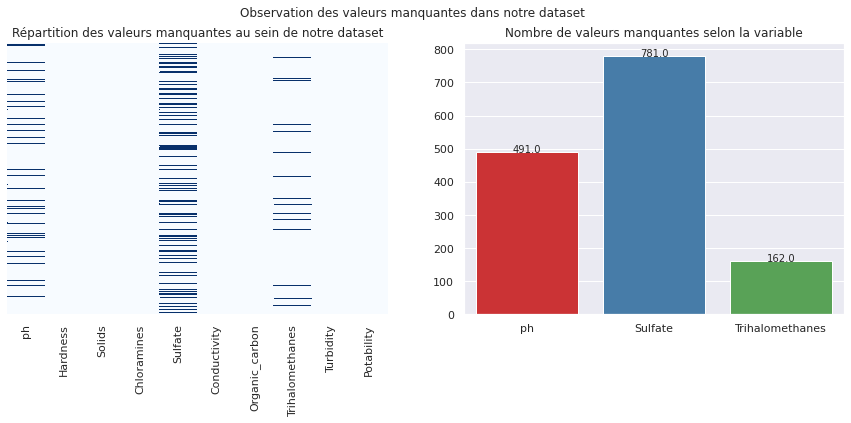

In [ ]:
missing_values=["ph", "Sulfate", "Trihalomethanes"]

fig, axes = plt.subplots(1, 2, figsize = (15, 5))
fig.suptitle("Observation des valeurs manquantes dans notre dataset")

#Répartition des valeurs manquantes dans le dataset
sns.heatmap(eau_df.isnull(), yticklabels=False, cbar=False, cmap = "Blues", ax=axes[0])
axes[0].set_title("Répartition des valeurs manquantes au sein de notre dataset")

#Nombre de valeurs manquantes uniquement pour les features qui en contiennent
missing_values_barplot=sns.barplot(y=eau_df[missing_values].isnull().sum(), 
                                   x=missing_values, 
                                   ax=axes[1])
add_label_barplot(missing_values_barplot)
axes[1].set_title("Nombre de valeurs manquantes selon la variable")

**Observations**:
*   Comme évoqué précédemment, nous trouvons des valeurs manquantes dans trois variables : **ph**, **Sulfate** et **Trihalomethanes**.

*   Le graphique à droite nous permet de statuer sur le nombre de valeurs manquantes. Elles sont plutôt nombreuses, 491 pour **ph**, 781 pour **Sulfate** et 162 dans le cas de **Trihalomethanes**.<br> Ainsi, nous décidons de les remplacer plutôt que de les supprimer.

*   Le graphique à gauche nous renseigne sur la catégorie des valeurs manquantes. Visuellement, la probabilité qu'une observation manque, pour une variable considérée, ne semble pas dépendre des observations manquantes des autres variables. Donc, il nous paraît correcte de supposer que les valeurs manquantes sont **Missing At Random**.

### Traitement des valeurs manquantes
Nous allons considérer uniquement la variable **"Sulfate"** dans le but de tester plusieurs méthodes de remplacement et de déterminer la plus adaptée. Ce choix n'est pas aléatoire, **"Sulfate"** est la variable qui possède le plus de valeurs manquantes.

Avant toute chose, on visualise **"Sulfate"** en l'état afin d'avoir un élément de comparaison (témoin).

Text(0.5, 1.0, 'Graphique en courbes des 50 premières observations')

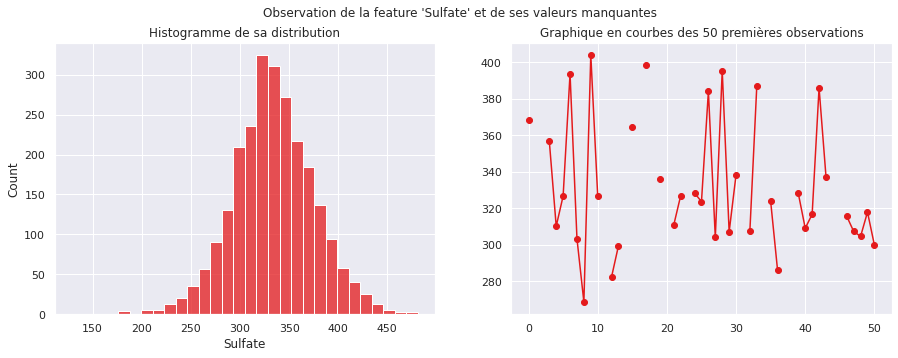

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (15,5))
fig.suptitle("Observation de la feature 'Sulfate' et de ses valeurs manquantes")

# On plot l'histogramme de la variable
sns.histplot(eau_df["Sulfate"], kde=False, bins=30, ax=axes[0])
axes[0].set_title("Histogramme de sa distribution")

# On plot quelques observations pour observer les valeurs manquantes
axes[1].plot(eau_df.loc[0:50,"Sulfate"], marker = "o")
axes[1].set_title("Graphique en courbes des 50 premières observations")

#### Remplacement par interpolation

##### Interpolation linéaire
Notre première approche consiste en une interpolation linéaire des données.

In [ ]:
eau_df_linear=eau_df.copy()
eau_df_linear= eau_df_linear.interpolate(method="linear")

Observons le résultat :

In [ ]:
# Définition d'une fonction pour afficher les résultats de la méthode utilisée pour remplacer les valeurs manquantes
def plot_result_imputer(titre, data):
  fig, axes = plt.subplots(1, 3, figsize = (18,5))
  fig.suptitle(titre)

  # On plot l'histogramme de la variable après application de la méthode
  sns.histplot(data["Sulfate"], kde=False, bins=30, ax=axes[0])
  axes[0].set_title("Histogramme de sa distribution")

  # On plot la variable pour observer la qualité de l'interpolation linéaire
  axes[1].plot(eau_df["Sulfate"], 
               marker=".", 
               linestyle="", 
               label = "Observation")
  axes[1].plot(np.where(eau_df["Sulfate"].isnull()==True, 
                        data["Sulfate"], 
                        None), 
               marker =".", 
               linestyle="", 
               label="Interpolation")
  axes[1].set_title("Nuage des points observés et interpolés")
  axes[1].legend(loc="lower left")

  # On plot la variable pour observer les valeurs manquantes
  axes[2].plot(data.loc[0:50,"Sulfate"], 
               marker ="o", 
               label="Interpolation", 
               color = "#377eb8")
  axes[2].plot(eau_df.loc[0:50,"Sulfate"], 
               marker = "o", 
               label = "Observation", 
               color = "#e41a1c")
  axes[2].set_title("Graphique en courbes des 50 premières observations")
  axes[2].legend(loc="lower left")

  # On sauvegarde notre figure
  plt.savefig(titre)

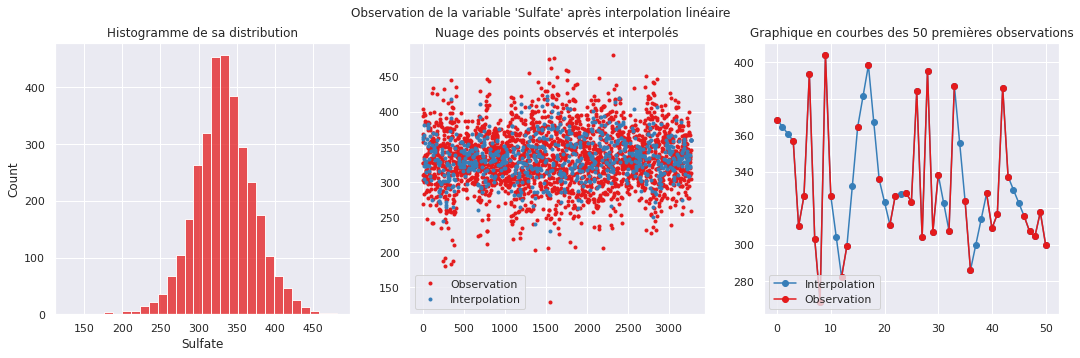

In [ ]:
plot_result_imputer("Observation de la variable 'Sulfate' après interpolation linéaire", 
                    eau_df_linear)

**Observations :**
*   (Histogramme) La distribution de la variable n'est pas trop fortement impactée par l'interpolation linéaire. 
*   (Histogramme) Il y a beaucoup plus d'observations qui ont une valeur qui est comprise entre 300 et 350.
*   (Nuage) Les points interpolés ont une variance plus faible que les observations réelles, certaines fluctuations extrêmes ne sont pas reproduites par l'interpolation linéaire. 

(0.0, 10.0)

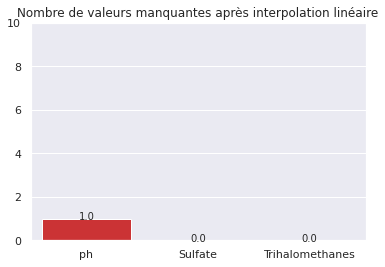

In [ ]:
# On affiche le nombre de valeurs manquantes après interpolation linéaire
missing_after_linear = sns.barplot(y=eau_df_linear[missing_values].isnull().sum(), x=missing_values)
add_label_barplot(missing_after_linear)
missing_after_linear.set_title("Nombre de valeurs manquantes après interpolation linéaire")
missing_after_linear.set_ylim((0,10))

Ce graphique nous permet de mettre en lumière l'une des problématiques de cette méthode, certaines observations ne peuvent pas être interpolées. Ainsi, un très faible nombre de valeurs manquantes est encore présent au sein de nos données après l'interpolation linéaire.

##### Interpolation polynomiale
Nous décidons désormais de réaliser une interpolation polynomiale d'ordre 2.

In [ ]:
eau_df_polynomial=eau_df.copy()
eau_df_polynomial= eau_df_polynomial.interpolate(method="polynomial", order=2)

Observons le résultat :

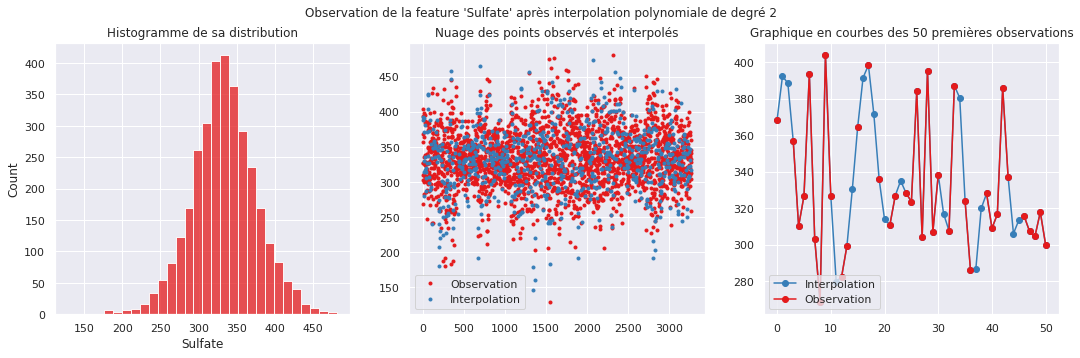

In [ ]:
plot_result_imputer("Observation de la feature 'Sulfate' après interpolation polynomiale de degré 2", 
                    eau_df_polynomial)

**Observations :**
*   (Histogramme) La distribution de la variable n'est pas trop impactée par l'interpolation polynomiale. 
*   (Histogramme) Les observations avec une valeur comprise entre 300 et 350 sont toujours très nombreuses, mais moins que dans le cas de l'interpolation linéaire.
*   (Nuage) Les points interpolés ont la même variance que les observations réelles. La fluctuation des points interpolés est similaire à celle des observations, y compris pour les plus extrêmes.
*   (Courbes) Le positionnement des points interpolés semblent davantage conforme que lors de l'interpolation linéaire.

(0.0, 10.0)

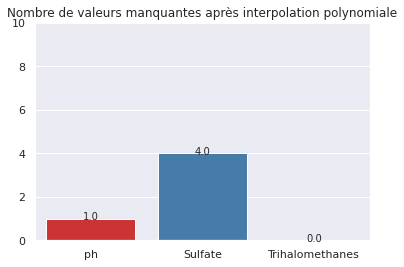

In [ ]:
# On affiche le nombre de valeurs manquantes après interpolation polynomiale
missing_after_poly = sns.barplot(y=eau_df_polynomial[missing_values].isnull().sum(), x=missing_values)
add_label_barplot(missing_after_poly)
missing_after_poly.set_title("Nombre de valeurs manquantes après interpolation polynomiale")
missing_after_poly.set_ylim((0,10))

Nous retrouvons la problématique déjà évoquée dans le cadre de l'interpolation linéaire. Certains points n'ont pas pu être interpolés.
<br>
<br>
**Conclusion sur le remplacement par interpolation :**
<br>Ainsi, même si les méthodes d'interpolation présentent plusieurs avantages, nous décidons de ne pas retenir ces solutions car elles ne permettent pas de remplacer l'ensemble des valeurs manquantes.

#### Imputation grâce aux méthodes vues en cours

##### Imputation par la moyenne
Pour commencer, nous essayons de remplacer les valeurs manquantes, pour une variable X considérée, par la moyenne de X.

In [ ]:
eau_df_moyenne=eau_df.copy()

# On remplace les valeurs manquantes dans ph
meanPh=eau_df_moyenne['ph'].mean()
eau_df_moyenne['ph'].fillna(meanPh,inplace=True)

# On remplace les valeurs manquantes dans Sulfate
meanSulf= eau_df_moyenne['Sulfate'].mean()
eau_df_moyenne['Sulfate'].fillna(meanSulf,inplace=True)

# On remplace les valeurs manquantes dans Trihalomethanes
meanTri= eau_df_moyenne['Trihalomethanes'].mean()
eau_df_moyenne['Trihalomethanes'].fillna(meanTri,inplace=True)

Observons le résultat :

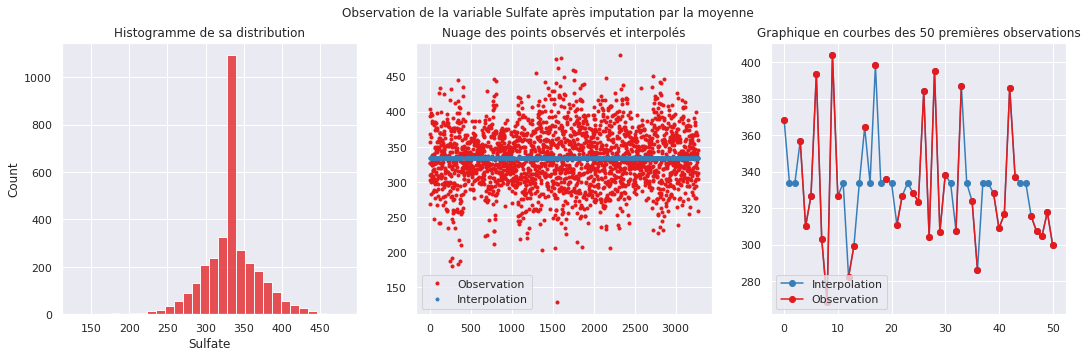

In [ ]:
plot_result_imputer("Observation de la variable Sulfate après imputation par la moyenne",
                    eau_df_moyenne)

**Observations :**
*   (Histogramme) La distribution de la variable est fortement impactée par l'imputation par la moyenne. Vu le grand nombre de valeurs manquantes, cette méthode n'est peut-être pas la plus adaptée.
*   (Histogramme) Les observations avec une valeur comprise entre 330 et 340 sont beaucoup plus nombreuses. C'est un résultat attendu, car la moyenne de **"Sulfate"** est d'environ 333.
*   (Nuage) Les points interpolés se répartissent sur une ligne, qui correspond à la moyenne de la variable. Cette méthode ne reproduit pas la variabilité des observations.

##### Imputation par la moyenne par classe
Après quelques recherches, nous avons trouvé cette solution qui diffère légèrement de la précédente. 
<br>Nous remplaçons les valeurs manquantes labellisées comme potable, pour une variable X considérée, par la moyenne des observations de X labellisées comme potable. Nous procédons de manière équivalente pour la classe non potable.
<br>Cette méthode, contrairement à la précédente, conserve la moyenne de chaque classe (potable et non potable). Dans le meilleur des cas, cela devrait permettre d'accentuer leur séparabilité. Dans le pire des cas, il y a moins de bruit qui est ajouté avec cette méthode, en comparaison avec la précédente.

In [ ]:
eau_df_moyenne_ameliore=eau_df.copy()

# On remplace les valeurs manquantes dans ph pour la classe non potable
ph_mean = eau_df_moyenne_ameliore[eau_df_moyenne_ameliore['Potability'] == 0]['ph'].mean(skipna=True)
eau_df_moyenne_ameliore.loc[(eau_df_moyenne_ameliore['Potability'] == 0) & (eau_df_moyenne_ameliore['ph'].isna()), 
                            'ph'] = ph_mean

# On remplace les valeurs manquantes dans ph pour la classe potable
ph_mean_1 = eau_df_moyenne_ameliore[eau_df_moyenne_ameliore['Potability'] == 1]['ph'].mean(skipna=True)
eau_df_moyenne_ameliore.loc[(eau_df_moyenne_ameliore['Potability'] == 1) & (eau_df_moyenne_ameliore['ph'].isna()), 
                            'ph'] = ph_mean_1

# On remplace les valeurs manquantes dans Sulfate pour la classe non potable
sulf_mean = eau_df_moyenne_ameliore[eau_df_moyenne_ameliore['Potability'] == 0]['Sulfate'].mean(skipna=True)
eau_df_moyenne_ameliore.loc[(eau_df_moyenne_ameliore['Potability'] == 0) & (eau_df_moyenne_ameliore['Sulfate'].isna()), 
                            'Sulfate'] = sulf_mean

# On remplace les valeurs manquantes dans Sulfate pour la classe potable
sulf_mean_1 = eau_df_moyenne_ameliore[eau_df_moyenne_ameliore['Potability'] == 1]['Sulfate'].mean(skipna=True)
eau_df_moyenne_ameliore.loc[(eau_df_moyenne_ameliore['Potability'] == 1) & (eau_df_moyenne_ameliore['Sulfate'].isna()), 
                            'Sulfate'] = sulf_mean_1

# On remplace les valeurs manquantes dans Trihalomethanes pour la classe non potable
traih_mean = eau_df_moyenne_ameliore[eau_df_moyenne_ameliore['Potability'] == 0]['Trihalomethanes'].mean(skipna=True)
eau_df_moyenne_ameliore.loc[(eau_df_moyenne_ameliore['Potability'] == 0) & (eau_df_moyenne_ameliore['Trihalomethanes'].isna()), 
                            'Trihalomethanes'] = traih_mean

# On remplace les valeurs manquantes dans Trihalomethanes pour la classe potable
trah_mean_1 = eau_df_moyenne_ameliore[eau_df_moyenne_ameliore['Potability'] == 1]['Trihalomethanes'].mean(skipna=True)
eau_df_moyenne_ameliore.loc[(eau_df_moyenne_ameliore['Potability'] == 1) & (eau_df_moyenne_ameliore['Trihalomethanes'].isna()), 
                            'Trihalomethanes'] = trah_mean_1

Observons le résultat:

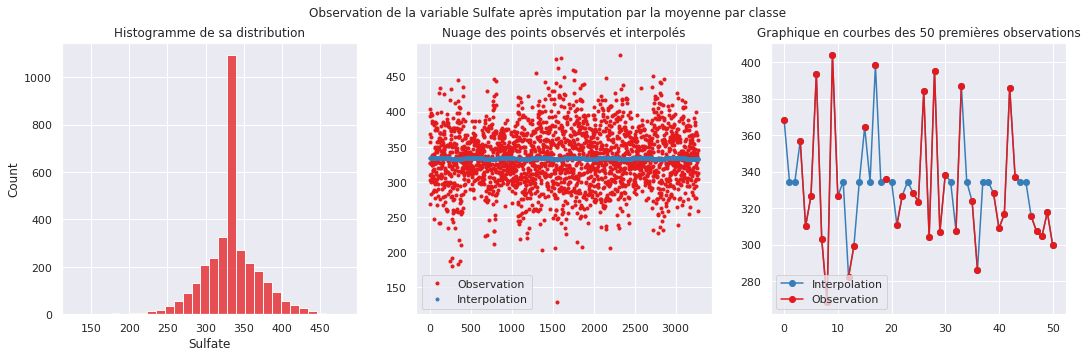

In [ ]:
plot_result_imputer("Observation de la variable Sulfate après imputation par la moyenne par classe",
                    eau_df_moyenne_ameliore)

##### Interpolation par la méthode de régression stochastique
Nous concluons cette partie avec une imputation par régression stochastique.

In [ ]:
it_imp = IterativeImputer(sample_posterior=True, random_state = 28)
data_iterative_imputer = it_imp.fit_transform(eau_df)
df_iterative_imputer = pd.DataFrame(data=data_iterative_imputer, 
                                    columns=eau_df.columns.values)

Observons le résultat :

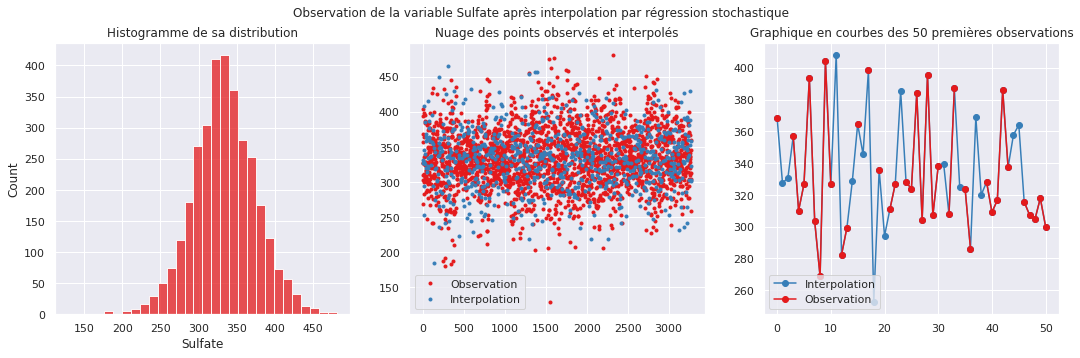

In [ ]:
plot_result_imputer("Observation de la variable Sulfate après interpolation par régression stochastique",
                    df_iterative_imputer)

**Observations :**
*   Ces graphiques sont très similaires à ceux obtenus par interpolation polynomiale.
*   Les remarques réalisées dans le cas de l'interpolation polynomiale sont vraies également ici.


**Conclusion sur le remplacement par les méthodes vues en cours :**
*   La régression stochastique est la meilleure solution, elle possède les qualités de l'interpolation polynomiale sans les inconvénients. En effet, toutes les valeurs manquantes ont étés remplacés.
<br>Dorénavant nous travaillerons sur les données issues de cette méthode.
*   L'interpolation par la moyenne ne nous paraît pas être une bonne solution car elle déforme trop la distribution de la variable. Néanmoins, nous décidons de l'utiliser sur certains modèles afin de confirmer ce raisonnement.



## **Entraînement des modèles**
Cette partie est consacrée à l'entraînement et à la comparaison des différents modèles dans le but de résoudre notre problème de classification.

In [ ]:
# Importation des dépendances pour la partie entraînement des modèles
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, accuracy_score, make_scorer

# Pour la selection de modèles
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

#Pour la création de pipeline
from sklearn.pipeline import Pipeline

#Modeles
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

### Entraînement à partir d'un dataset où l'on a remplacé les valeurs manquantes
Nous réutilisons le jeu de données défini précédemment, dans lequel les valeurs manquantes sont remplacées par régression stochastique.

Dans le but d'évaluer les performances de nos modèles, nous avons choisis deux mesures de performances:
*   la justesse (acuracy) qui permet de connaître le pourcentage d'instances correctement classifiées.
*   la précision qui correspond au nombre d'observations correctement classifiées parmi l'ensemble des prédictions. <br> Nous l'avons évoqué précédemment, nous voulons éviter autant que possible les faux positifs, or une valeur de précision élevée implique un faible taux de faux positifs.


In [ ]:
# On sépare les données et les labels
X = df_iterative_imputer.drop(columns='Potability',axis=1)
Y = df_iterative_imputer['Potability']

# On créer nos datasets d'entraînement et de test
X_train,X_test,Y_train,Y_test = train_test_split(X,Y, test_size =0.2, 
                                                 stratify=Y,
                                                 random_state=28)

# On définit notre score de précision
precision=make_scorer(precision_score)

In [ ]:
# On définit une fonction qui nous sera utile pour présenter nos résultat
def plot_result_grid_search(suptitle, grid_search):
  fig, axes = plt.subplots(1, 2, figsize = (15,5))
  fig.suptitle(suptitle)

  # On définit notre axe des abcisses
  abcisse = range(len(grid_search.cv_results_["mean_train_Accuracy"]))

  # On plot la précision et l'accuracy sur le jeu d'entraînement
  sns.lineplot(x=abcisse, y=grid_search.cv_results_["mean_train_Accuracy"], label="Accuracy", ax=axes[0])
  sns.lineplot(x=abcisse, y=grid_search.cv_results_["mean_train_Precision"], label="Precision", ax=axes[0])
  axes[0].set_title("Performances sur le jeu d'entraînement selon le modèle")

  sns.lineplot(x=abcisse, y=grid_search.cv_results_["mean_test_Accuracy"], label="Accuracy", ax=axes[1])
  sns.lineplot(x=abcisse, y=grid_search.cv_results_["mean_test_Precision"], label="Precision", ax=axes[1])
  axes[1].set_title("Performances sur le jeu de validation selon le modèle")
  plt.legend()
  plt.savefig(suptitle)

#### K-nearest neighbors
La première méthode que nous allons implémenter et tester est un K-nearest neighbors.


Nous utilisons une grille afin d'ajuster nos hyper-paramètres. Nous choisissons comme variable à ajuster le nombre de voisin, la manière de calculer les poids, ainsi que p qui correspond au type de distance.

In [ ]:
scale=StandardScaler()
KNN = KNeighborsClassifier()
pipe=Pipeline(steps=[('scaler', scale),('knn',KNN)])
#training the model with grid search
param_grid = {'knn__n_neighbors' : [2,5,7,10],
              'knn__weights' : ['uniform','distance'],
              'knn__p' : [1,2]}
 
grid = GridSearchCV(pipe, param_grid, 
                     return_train_score=True,
                     scoring={"Accuracy":"accuracy","Precision":precision},
                     refit="Accuracy")
grid.fit(X_train,Y_train)

#Accuracy of the train data
Y_train_predictionKNN=grid.predict(X_train)
training_data_accuracyKNN= accuracy_score(Y_train_predictionKNN, Y_train)
print('Accuracy score of training data :', training_data_accuracyKNN)

#Accuracy of the test data
Y_test_predictionKNN=grid.predict(X_test)
test_data_accuracyKNN= accuracy_score(Y_test_predictionKNN, Y_test)
best_knn_precision=precision_score(Y_test,Y_test_predictionKNN)
print('Accuracy score of test data :', test_data_accuracyKNN)
print("Le meilleur modèle a une precision de {0} sur le jeu de test.".format(best_knn_precision))
print("les parametres du meilleur model sont:"+str(grid.best_params_))

Accuracy score of training data : 0.6988549618320611
Accuracy score of test data : 0.6265243902439024
Le meilleur modèle a une precision de 0.5504587155963303 sur le jeu de test.
les parametres du meilleur model sont:{'knn__n_neighbors': 10, 'knn__p': 2, 'knn__weights': 'uniform'}


Nous remarquons que notre modèle est en situation de sur-apprentissage et que notre precision n'est pas terrible.

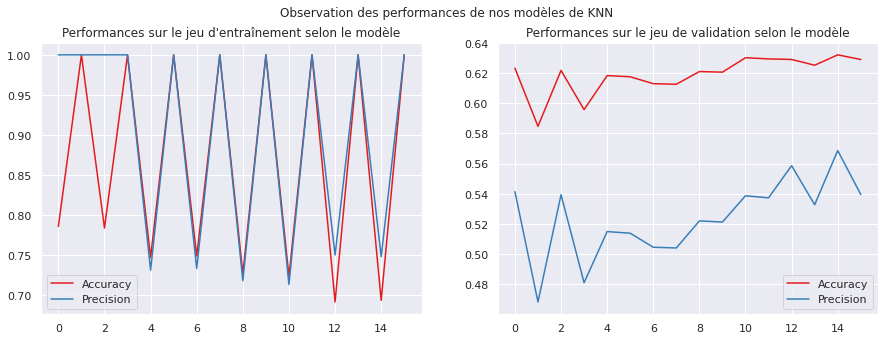

In [ ]:
# On plot nos résultats
plot_result_grid_search("Observation des performances de nos modèles de KNN", grid)

In [ ]:
from sklearn.model_selection import StratifiedKFold, KFold

k = 10
kf = StratifiedKFold(n_splits=k, random_state=None)
model = KNeighborsClassifier(n_neighbors=10 ,p=2 ,weights='uniform')
acc_score = []

for train_index , test_index in kf.split(X_train,Y_train):
    X_train1 , X_test1 = X.iloc[train_index,:],X.iloc[test_index,:]
    y_train1 , y_test1 = Y[train_index] , Y[test_index]
     
    model.fit(X_train1,y_train1)
    pred_values = model.predict(X_train1)
     
    acc = accuracy_score(pred_values , y_train1)
    acc_score.append(acc)
     
avg_acc_score = sum(acc_score)/k

print('accuracy of each fold - {}'.format(acc_score))
print('Avg accuracy : {}'.format(avg_acc_score))

print('accuracy of model - {}'.format(accuracy_score(model.predict(X_test) , Y_test)))

accuracy of each fold - [0.6530958439355385, 0.6759966072943172, 0.6743002544529262, 0.6530958439355385, 0.6806615776081425, 0.6717557251908397, 0.6628498727735369, 0.6751484308736218, 0.6581849024597116, 0.6738761662425785]
Avg accuracy : 0.6678965224766752
accuracy of model - 0.6310975609756098


#### Utilisation de modèle bayesien

In [ ]:
NB = GaussianNB()
pipe=Pipeline(steps=[('scaler', scale),('NB',NB)])

#training the model
param_grid = {"NB__var_smoothing" :np.logspace(0,-9, num=100)}
grid_nb = GridSearchCV(pipe,
                       param_grid,
                       return_train_score=True,
                       scoring={"Accuracy":"accuracy","Precision":precision},
                       refit="Accuracy")
grid_nb.fit(X_train,Y_train)

#Accuracy of the train data
Y_train_predictionNB=grid_nb.predict(X_train)
training_data_accuracyNB= accuracy_score(Y_train_predictionNB, Y_train)
print('Accuracy score of training data :', training_data_accuracyNB)

#Accuracy of the test data
Y_test_predictionNB=grid_nb.predict(X_test)
test_data_accuracyNB= accuracy_score(Y_test_predictionNB, Y_test)
best_NB_precision=precision_score(Y_test,Y_test_predictionNB)
print('Accuracy score of test data :', test_data_accuracyNB)
print('Precision score of test data :', best_NB_precision )
print("les parametres du meilleur model sont:"+str(grid_nb.best_params_))

Accuracy score of training data : 0.6225190839694656
Accuracy score of test data : 0.6204268292682927
Precision score of test data : 0.6206896551724138
les parametres du meilleur model sont:{'NB__var_smoothing': 0.533669923120631}


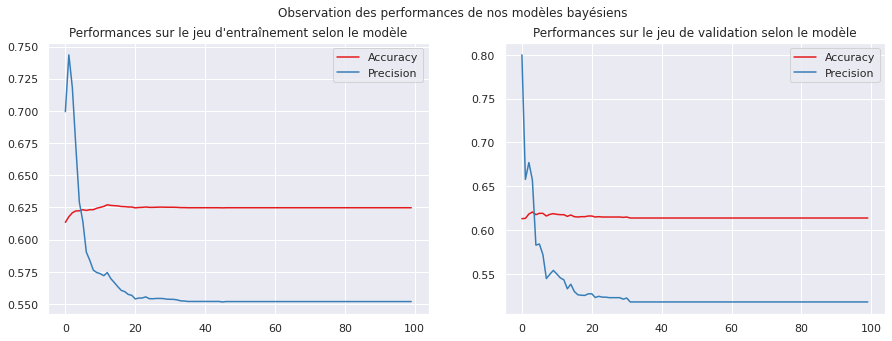

In [ ]:
plot_result_grid_search("Observation des performances de nos modèles bayésiens", grid_nb)

La courbe du score de la précision nous empêche de correctement observer notre justesse. Remédions à cela.

Text(0.5, 1.0, 'Accuracy sur le jeu de validation selon le modèle')

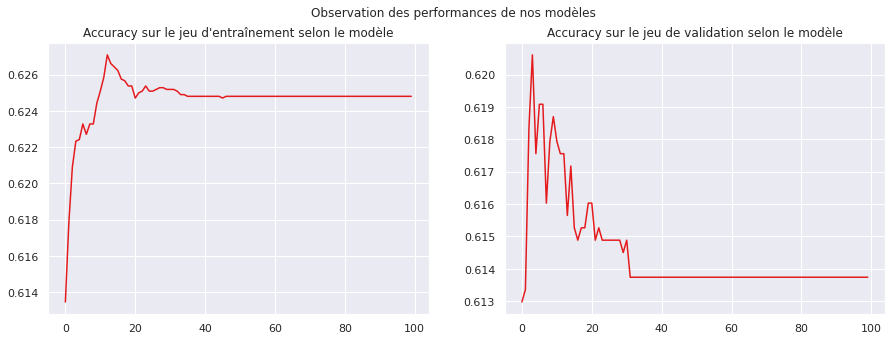

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (15,5))
fig.suptitle("Observation des performances de nos modèles")

sns.lineplot(x=range(len(grid_nb.cv_results_["mean_train_Accuracy"])),y=grid_nb.cv_results_["mean_train_Accuracy"], ax=axes[0])
axes[0].set_title("Accuracy sur le jeu d'entraînement selon le modèle")

sns.lineplot(x=range(len(grid_nb.cv_results_["mean_test_Accuracy"])),y=grid_nb.cv_results_["mean_test_Accuracy"], ax=axes[1])
axes[1].set_title("Accuracy sur le jeu de validation selon le modèle")

####  Support Vector Machine linéaire

Calcul très long d'ou les résultats non afficher

Nous allons essayer d'entrainer un svm lineaire en modifiant seulement le paramètre de régularisation car ce modéle est très long en temps de calcul.

In [ ]:
scale=StandardScaler()
linear_svm=SVC(kernel='linear')
pipe=Pipeline(steps=[('scaler', scale),('svm',linear_svm)])
param_grid = {'svm__C': [0.1, 1, 10, 100, 1000]}
 


grid_svm=GridSearchCV(pipe,param_grid,return_train_score=True)
grid_svm.fit(X_train,Y_train)



KeyboardInterrupt: ignored

Affichons les résultats.

In [ ]:
plot_result_grid_search("Observation des performances de nos modèles bagging", grid_svm)

In [ ]:
predictions_svm_linear=grid_svm.best_estimator_.predict(X_test)
best_svm_precision_linear = precision_score(Y_test,predictions_svm)

####  Support Vector Machine non linéaire

Nous allons mettre en place un pipeline comportant deux étapes:
*   Mise à l'échelle des données car les machines à support de vecteurs sont sensibles aux différentes échelles.
*   Entraînement du modèle de SVM non linéaire.

Nous définissons également une grille de recherche pour ajuster les paramètres du SVM :
*   nous testons deux fonctions noyaux, base radiale ainsi que polynomiale de degré 1, 2, 3 et 4.
*   dans la partie "analyse descriptive", nous avons constaté que 61% des observations sont des eaux non potables. Nous souhaitons tester si l'ajout d'un poids aux classes impacte nos performances.



In [ ]:
%%capture
# Mise en place de la pipeline
scaler = StandardScaler()
svm = SVC(random_state=28)
pipe = Pipeline(steps=[("scaler", scaler), ("svm", svm)])

# On définit les paramètres de notre GridSearch
param_grid = {
    "svm__kernel": ["poly", "rbf"],
    "svm__degree": [2, 3, 4],
    "svm__gamma": ["scale", "auto"],
    "svm__C": [0.5, 1.0, 1.5],
    "svm__class_weight": [None, "balanced"]
}

# On définit puis on entraîne notre GridSearch
gs_svm = GridSearchCV(pipe, param_grid, 
                      return_train_score=True, 
                      scoring={"Accuracy":"accuracy",
                               "Precision":precision},
                      refit="Accuracy")
gs_svm.fit(X_train, Y_train)

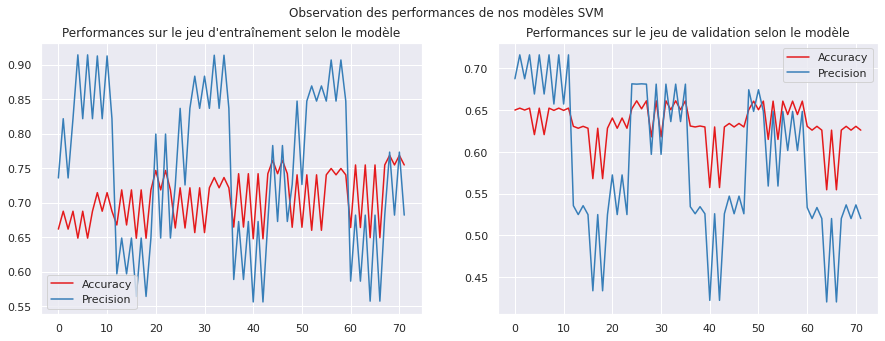

In [ ]:
plot_result_grid_search("Observation des performances de nos modèles SVM",gs_svm)

Observons les résultats obtenus sur nos jeux d'entraînement et de validation.

In [ ]:
for i in range(3,15):
  print("Modele {0} : ".format(i), gs_svm.cv_results_["params"][i])
for i in [40, 42, 64]:
  print("Modele {0} : ".format(i), gs_svm.cv_results_["params"][i])
print("Meilleure Modele : ", gs_svm.best_params_)

Modele 3 :  {'svm__C': 0.5, 'svm__class_weight': None, 'svm__degree': 2, 'svm__gamma': 'auto', 'svm__kernel': 'rbf'}
Modele 4 :  {'svm__C': 0.5, 'svm__class_weight': None, 'svm__degree': 3, 'svm__gamma': 'scale', 'svm__kernel': 'poly'}
Modele 5 :  {'svm__C': 0.5, 'svm__class_weight': None, 'svm__degree': 3, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}
Modele 6 :  {'svm__C': 0.5, 'svm__class_weight': None, 'svm__degree': 3, 'svm__gamma': 'auto', 'svm__kernel': 'poly'}
Modele 7 :  {'svm__C': 0.5, 'svm__class_weight': None, 'svm__degree': 3, 'svm__gamma': 'auto', 'svm__kernel': 'rbf'}
Modele 8 :  {'svm__C': 0.5, 'svm__class_weight': None, 'svm__degree': 4, 'svm__gamma': 'scale', 'svm__kernel': 'poly'}
Modele 9 :  {'svm__C': 0.5, 'svm__class_weight': None, 'svm__degree': 4, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}
Modele 10 :  {'svm__C': 0.5, 'svm__class_weight': None, 'svm__degree': 4, 'svm__gamma': 'auto', 'svm__kernel': 'poly'}
Modele 11 :  {'svm__C': 0.5, 'svm__class_weight': None,

**Observations :**
*   nous remarquons trois schémas avec des mauvais scores, ils correspondent aux modèles où un poids a été ajouté aux classes.
*   globalement, les meilleures performances en termes d'accuracy sont atteintes avec une fonction noyau de base radiale. Clairement, nous pouvons conclure qu'elle est adaptée à nos données et à notre problème.
*   globalement, les meilleures performances en termes de précision sont atteintes avec un coefficient de régulation (C) faible, c'est-à-dire avec des marges plus souples.
*   nous décidons de conserver le meilleur modèle en termes d'accuracy. Il utilise une fonction noyau de base radiale et un coefficient de régulation à 1. 

<br> Par la suite, nous conservons le meilleur modèle et nous allons tester ses performances sur le jeu de test.


In [ ]:
predictions_svm=gs_svm.best_estimator_.predict(X_test)
best_svm_precision = precision_score(Y_test,predictions_svm)

In [ ]:
print("Le meilleur modèle a une accuracy de {0} sur le jeu de test.".format(gs_svm.best_estimator_.score(X_test,Y_test)))
print("Le meilleur modèle a une precision de {0} sur le jeu de test.".format(best_svm_precision))

Le meilleur modèle a une accuracy de 0.6798780487804879 sur le jeu de test.
Le meilleur modèle a une precision de 0.7169811320754716 sur le jeu de test.


**Conclusion SVM non linéaire**
<br>Le modèle a une justesse de 68% et une précision de 72% sur le jeu de test. Ce sont des résultats corrects, et il s'agit des meilleurs scores jusqu'à maintenant.

#### Méthode ensembliste - Bagging

Cette fois-ci, nous ne procédons pas à la mise à l'échelle des données car les arbres de décisions y sont insensibles.

Nous définissons une grille de recherche pour ajuster les paramètres de notre modèle :
*   nous augmentons progressivement le nombre de classifieurs, de 20 jusqu'à 250 inclut avec un pas de 20.
*   nous augmentons également de manière progressive la valeur du paramètre "max_samples".
*   nous laissons la valeur par défaut du paramètre "max_features" car dans un bagging, le partitionnement de l'espace s'effectue sur l'ensemble des variables.

In [ ]:
bagging = BaggingClassifier(random_state=28)

# On définit les paramètres de notre GridSearch
param_grid = {
    "n_estimators": np.arange(20, 250, 20),
    "max_samples": [0.3, 0.5, 0.7]
}

# On définit puis on entraîne notre GridSearch
gs_bag = GridSearchCV(bagging, param_grid, 
                      return_train_score=True,
                      scoring={"Accuracy":"accuracy",
                               "Precision":precision},
                      refit="Accuracy")
gs_bag.fit(X_train, Y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=BaggingClassifier(base_estimator=None, bootstrap=True,
                                         bootstrap_features=False,
                                         max_features=1.0, max_samples=1.0,
                                         n_estimators=10, n_jobs=None,
                                         oob_score=False, random_state=28,
                                         verbose=0, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'max_samples': [0.3, 0.5, 0.7],
                         'n_estimators': array([ 20,  40,  60,  80, 100, 120, 140, 160, 180, 200, 220, 240])},
             pre_dispatch='2*n_jobs', refit='Accuracy', return_train_score=True,
             scoring={'Accuracy': 'accuracy',
                      'Precision': make_scorer(precision_score)},
             verbose=0)

Observons les résultats obtenus sur nos jeux d'entraînement et de validation.

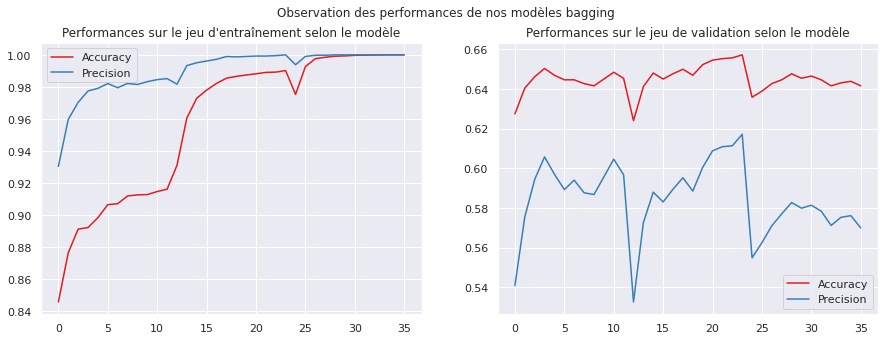

In [ ]:
plot_result_grid_search("Observation des performances de nos modèles bagging", gs_bag)

In [ ]:
for i in range(7,13):
  print("Modele {0} : ".format(i), gs_bag.cv_results_["params"][i])
for i in range(26,30):
  print("Modele {0} : ".format(i), gs_bag.cv_results_["params"][i])
print("Meilleure Modele : ", gs_bag.best_params_)

Modele 7 :  {'max_samples': 0.3, 'n_estimators': 160}
Modele 8 :  {'max_samples': 0.3, 'n_estimators': 180}
Modele 9 :  {'max_samples': 0.3, 'n_estimators': 200}
Modele 10 :  {'max_samples': 0.3, 'n_estimators': 220}
Modele 11 :  {'max_samples': 0.3, 'n_estimators': 240}
Modele 12 :  {'max_samples': 0.5, 'n_estimators': 20}
Modele 26 :  {'max_samples': 0.7, 'n_estimators': 60}
Modele 27 :  {'max_samples': 0.7, 'n_estimators': 80}
Modele 28 :  {'max_samples': 0.7, 'n_estimators': 100}
Modele 29 :  {'max_samples': 0.7, 'n_estimators': 120}
Meilleure Modele :  {'max_samples': 0.5, 'n_estimators': 240}


**Observations:**
*  Il semble que plus l'échantillon utilisé pour entraîner l'arbre est grand et plus nous sommes susceptibles de voir l'apparition d'un plateau sur nos courbes d'apprentissages. Ce plateau signifie que le modèle n'apprend plus, ses performances ne progressent plus.
*    Nous remarquons une situation d'overfitting à partir du 25ème modèle. Nos scores sur les données d'entraînement sont parfait mais ils diminuent sur les données de validation. On en conclut que 0.7 est une valeur trop forte pour le paramètre "max_samples".
*   Le meilleur modèle est un bagging constitué de 240 classifieurs avec un tirage avec remise de la moitié des observations.

<br> Par la suite, nous conservons le meilleur modèle et nous allons tester ses performances sur le jeu de test.

In [ ]:
predictions_bag=gs_bag.best_estimator_.predict(X_test)
best_bag_precision = precision_score(Y_test,predictions_bag)

In [ ]:
print("Le meilleur modèle a une accuracy de {0} sur le jeu de test.".format(gs_bag.best_estimator_.score(X_test,Y_test)))
print("Le meilleur modèle a une precision de {0} sur le jeu de test.".format(best_bag_precision))

Le meilleur modèle a une accuracy de 0.6890243902439024 sur le jeu de test.
Le meilleur modèle a une precision de 0.6666666666666666 sur le jeu de test.


**Conclusion Bagging**
<br>Le modèle a une justesse de 69% et une précision de 67% sur le jeu de test. La justesse est légèrement plus élevée (+1%) par rapport à celle obtenue avec un SVM non linéaire. Nous nous intéressons aussi à la précision du modèle, elle est plus faible (-5%) que celle obtenue avec le SVM non linéaire. Nous rejetons donc ce modèle pour ce problème de classification.

#### Méthode ensembliste - Random Forest

Cette fois-ci encore, nous ne procédons pas à la mise à l'échelle des données car les arbres de décisions y sont insensibles.

Nous définissons une grille de recherche pour ajuster les paramètres de notre modèle :
*   nous augmentons progressivement le nombre de classifieurs, de 80 jusqu'à 250 inclut avec un pas de 20.
*   nous augmentons de manière progressive la valeur du paramètre "max_samples". Nous nous basons sur les résultats du bagging  (0.3 trop faible et 0.7 trop élevé) pour choisir ces valeurs.
*   nous augmentons de manière progressive la valeur du paramètre "max_features".

In [ ]:
from sklearn.model_selection import StratifiedKFold, KFold

RF = RandomForestClassifier(random_state=28)
# On définit les paramètres de notre GridSearch
param_grid = {
    "n_estimators": np.arange(80, 250, 20),
    "max_samples": [0.4, 0.6],
    "max_features": [0.3, 0.5, 0.7, 0.8, 1.0]
}

# On définit puis on entraîne notre GridSearch
gs_rf = GridSearchCV(RF, param_grid, 
                     return_train_score=True,
                     scoring={"Accuracy":"accuracy",
                              "Precision":precision},
                     refit="Accuracy",
                     cv=StratifiedKFold())
gs_rf.fit(X_train, Y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,...
                                              oob_score=False, random_state=28,
                                              verbose=0, warm_start=False),
             iid='deprecated', n_jo

Observons les résultats obtenus sur nos jeux d'entraînement et de validation.

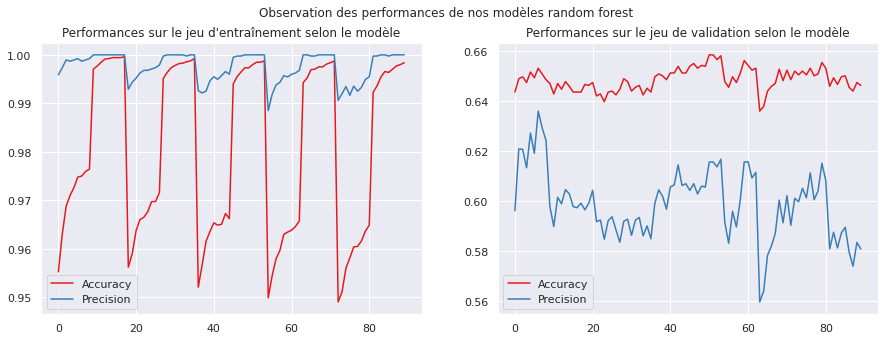

In [ ]:
plot_result_grid_search("Observation des performances de nos modèles random forest", gs_rf)

In [ ]:
print("Meilleure Modele : ", gs_rf.best_params_)

Meilleure Modele :  {'max_features': 0.7, 'max_samples': 0.6, 'n_estimators': 200}


**Observations :**
*   nous remarquons qu'un schéma se répète cinq fois dans le graphique de gauche. Chaque répétition correspond à une nouvelle valeur pour le paramètre "max_features". Ainsi, il semblerait que les performances sont équivalentes peu importe le nombre de variables que l'on utilise pour partitionner l'espace.
*   Le meilleur modèle est un random forest constitué de 180 classifieurs.

<br> Par la suite, nous conservons le meilleur modèle et nous allons tester ses performances sur le jeu de test.

In [ ]:
predictions_rf = gs_rf.best_estimator_.predict(X_test)
best_rf_precision = precision_score(Y_test, predictions_rf)

In [ ]:
print("Le meilleur modèle a une accuracy de {0} sur le jeu de test.".format(gs_rf.best_estimator_.score(X_test,Y_test)))
print("Le meilleur modèle a une precision de {0} sur le jeu de test.".format(best_rf_precision))

Le meilleur modèle a une accuracy de 0.6966463414634146 sur le jeu de test.
Le meilleur modèle a une precision de 0.6838709677419355 sur le jeu de test.


L'un des avantages des arbres de décision, c'est qu'ils sont facilement interprétable. Par la suite, nous nous intéressons à l'importance des variables.

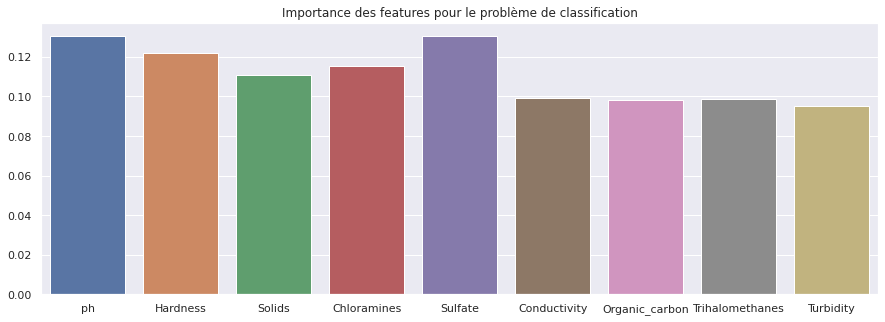

In [ ]:
plt.figure(figsize=(15,5))
plot = sns.barplot(y=gs_rf.best_estimator_.feature_importances_, x=X_train.columns.values, palette="deep")
plot.set_title("Importance des features pour le problème de classification")
plt.show()

**Conclusion Random Forest**
<br>Le modèle a une justesse de 70% et une précision de 68% sur le jeu de test. La justesse est légèrement meilleure (+2%) à celle obtenue avec un SVM non linéaire, donc cette seule métrique ne nous permet pas de conclure. Concernant la précision du modèle, elle est plus faible (-4%) que celle obtenue avec le SVM non linéaire mais meilleure que celle obtenue avec le bagging.
<br> De plus, ce modèle a pour avantage son explicabilité. Ici, l'ensemble des variables ont un poids à peu près équivalent dans la classification. Les variables **ph** et **Sulfate** semblent néanmoins être les plus importantes, or ce sont celles qui contiennent le plus de valeurs manquantes. On en déduit que la méthode utilisée pour remplacer nos valeurs manquantes a un grand impact sur les performances des algorithmes.

#### Utilisation de Boosting

On utilise une grille de recherche pour ajuster le learning rate, le nombre d'arbre et la profondeur maximum.

In [ ]:
Boosting=GradientBoostingClassifier()
scale=StandardScaler()
pipe=Pipeline(steps =[('scaler',scale),('Boosting',Boosting)])

param_grid = { 'Boosting__learning_rate' : [0.01,  0.05,  0.1, 0.15, 0.2],
              'Boosting__n_estimators' : [10,100,500],
              'Boosting__max_depth' : [3,5,7]} 

grid = GridSearchCV(pipe, param_grid, return_train_score=True)
grid.fit(X_train, Y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('Boosting',
                                        GradientBoostingClassifier(ccp_alpha=0.0,
                                                                   criterion='friedman_mse',
                                                                   init=None,
                                                                   learning_rate=0.1,
                                                                   loss='deviance',
                                                                   max_depth=3,
                                                                   max_features=None,
                

In [ ]:
plot_result_grid_search("Observation des performances de nos modèles random forest", grid)

Text(0.5, 1.0, 'Accuracy sur le jeu de validation selon le modèle')

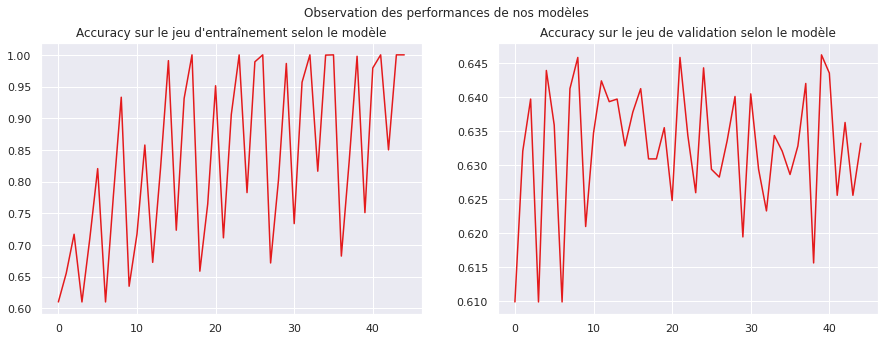

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (15,5))
fig.suptitle("Observation des performances de nos modèles")

sns.lineplot(x=range(len(grid.cv_results_["mean_train_score"])),y=grid.cv_results_["mean_train_score"], ax=axes[0])
axes[0].set_title("Accuracy sur le jeu d'entraînement selon le modèle")

sns.lineplot(x=range(len(grid.cv_results_["mean_train_score"])),y=grid.cv_results_["mean_test_score"], ax=axes[1])
axes[1].set_title("Accuracy sur le jeu de validation selon le modèle")

In [ ]:
#Accuracy of the train data
Y_train_predictionBoosting=grid.predict(X_train)
training_data_accuracyBoosting= accuracy_score(Y_train_predictionNB, Y_train)
print('Accuracy score of training data :', training_data_accuracyBoosting)

#Accuracy of the test data
Y_test_predictionBoosting=grid.predict(X_test)
test_data_accuracyBoosting= accuracy_score(Y_test_predictionBoosting, Y_test)
test_data_precisionBoosting=precision_score(Y_test_predictionBoosting, Y_test)
print('Accuracy score of test data :', test_data_accuracyBoosting)
print('Precision score of test data :', test_data_precisionBoosting)

Accuracy score of training data : 0.6368159203980099
Accuracy score of test data : 0.598014888337469
Precision score of test data : 0.20245398773006135


On remarque une accuracy acceptable en revanche la précision de ce modèle est très mauvaise. Ce qui laisse entendre un grand nombre de faux positif. Nous préférons donc le rejeter.

## **Challenge des deux meilleures modèles**
Désormais, nous travaillons avec les deux meilleurs modèles obtenus. Nous avons choisi le **SVM non linéaire** car ses performances en termes de précision sont les meilleures. Ainsi que le **Random Forest** car sa justesse est très bonne et son pouvoir d'explicabilité est plus grand.

<br>Dans cette partie, nous allons ré-entrainer ces algorithmes sur des jeux de données différents. En effet, nous savons maintenant que les variables les plus importantes pour ce problème de classification contiennent des valeurs manquantes. Nous souhaitons observer le comportement des modèles si l'on change la méthode de remplacement des valeurs manquantes.

<br>Nous réutilisons les jeux de données définis précédemment, dans lequel les valeurs manquantes sont remplacées par la moyenne.


In [ ]:
# Premier jeu de donnée : valeurs manquantes remplacées par la moyenne
# On sépare les données et les labels
X_moyenne = eau_df_moyenne.drop(columns='Potability',axis=1)
Y_moyenne = eau_df_moyenne['Potability']

# On créer nos datasets d'entraînement et de test
X_train_moy,X_test_moy,Y_train_moy,Y_test_moy = train_test_split(X_moyenne,
                                                                 Y_moyenne, 
                                                                 test_size =0.2, 
                                                                 stratify=Y_moyenne, 
                                                                 random_state=28)

In [ ]:
# Second jeu de donnée : valeurs manquantes remplacées par la moyenne par classe
# On sépare les données et les labels
X_moyenne_ameliore = eau_df_moyenne_ameliore.drop(columns='Potability',axis=1)
Y_moyenne_ameliore = eau_df_moyenne_ameliore['Potability']

# On créer nos datasets d'entraînement et de test
X_train_moy_a,X_test_moy_a,Y_train_moy_a,Y_test_moy_a = train_test_split(X_moyenne_ameliore,
                                                                         Y_moyenne_ameliore, 
                                                                         test_size =0.2, 
                                                                         stratify=Y_moyenne_ameliore, 
                                                                         random_state=28)

### Random Forest

In [ ]:
results_rf=[]
for train_test in [(X_train_moy, Y_train_moy), (X_train_moy_a, Y_train_moy_a)]:
  # On définit notre algorithme avec les paramètres définis dernièrement
  RF = RandomForestClassifier(random_state=28,
                              max_features= 0.7, 
                              max_samples= 0.6, 
                              n_estimators= 200)
  # On définit une cross-validation
  cv_result_rf = cross_validate(RF, train_test[0], train_test[1], cv=5,
                                scoring={"Accuracy":"accuracy",
                                         "Precision":precision})
  results_rf.append(round(cv_result_rf["test_Accuracy"].mean(), 2))
  results_rf.append(round(cv_result_rf["test_Precision"].mean(), 2))

# On place les resultat dans une dataframe (plus simple pour l'affichage)
df_rf=pd.DataFrame(results_rf, columns=["Valeur"])
df_rf["Label"]=["Accuracy", "Precision", "Accuracy", "Precision"]
df_rf["Méthode utilisée"]=["Moyenne", "Moyenne", "Moyenne par classe", "Moyenne par classe"]

### SVM non linéaire

In [ ]:
results_svm=[]
for train_test in [(X_train_moy, Y_train_moy), (X_train_moy_a, Y_train_moy_a)]:
  # On définit notre algorithme avec les paramètres définis dernièrement
  scaler = StandardScaler()
  svm = SVC(random_state=28, kernel="rbf", gamma="scale")
  pipe = Pipeline(steps=[("scaler", scaler), ("svm", svm)])

  # On définit une cross-validation
  cv_result_svm = cross_validate(pipe, train_test[0], train_test[1], cv=5,
                                 scoring={"Accuracy":"accuracy",
                                          "Precision":precision})
  
  results_svm.append(round(cv_result_svm["test_Accuracy"].mean(), 2))
  results_svm.append(round(cv_result_svm["test_Precision"].mean(), 2))

# On place les resultat dans une dataframe (plus simple pour l'affichage)
df_svm=pd.DataFrame(results_svm, columns=["Valeur"])
df_svm["Label"]=["Accuracy", "Precision", "Accuracy", "Precision"]
df_svm["Méthode utilisée"]=["Moyenne", "Moyenne", "Moyenne par classe", "Moyenne par classe"]

### Conclusion
Nous affichons nos résultats.

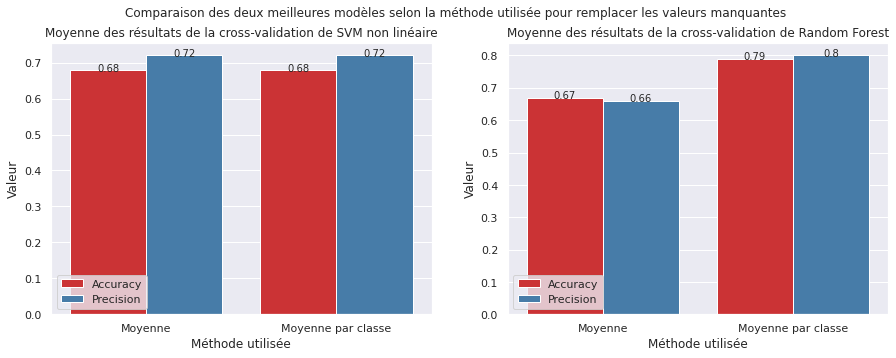

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (15,5))
fig.suptitle("Comparaison des deux meilleures modèles selon la méthode utilisée pour remplacer les valeurs manquantes")

# On plot la précision et l'accuracy du svm selon la méthode
bar_svm_result=sns.barplot(data = df_svm, x="Méthode utilisée", y="Valeur", hue="Label", ax=axes[0])
add_label_barplot(bar_svm_result)
axes[0].set_title("Moyenne des résultats de la cross-validation de SVM non linéaire")
axes[0].legend(loc="lower left")

# On plot la précision et l'accuracy du svm selon la méthode
bar_rf_result=sns.barplot(data = df_rf, x="Méthode utilisée", y="Valeur", hue="Label", ax=axes[1])
add_label_barplot(bar_rf_result)
axes[1].set_title("Moyenne des résultats de la cross-validation de Random Forest")
axes[1].legend(loc="lower left")

**Observations:**
*   quelle que soit la méthode utilisée pour remplacer les valeurs manquantes, les performances du SVM non linéaire sont équivalentes.
*   les résultats en ce qui concerne le Random Forest sont plus intéressants. Nous constatons une baisse des scores, -3% pour l'accuracy et -2% pour la précision, si l'on impute les valeurs manquantes par la moyenne. Par contre, si l'on utilise la moyenne de chaque classe les performances sont bien meilleures. L'algorithme  atteint une accuracy de 79% (+9%) et une précision de 80% (+10%).



## **Conclusion**

Tout au long de ce notebook, nous avons implémenté plusieurs méthodes et algorithmes afin de résoudre au mieux au problème de classification. Rappelons-le, il s'agissait de déterminer si une eau était potable ou pas.
<br> Le premier challenge concerné le remplacement des valeurs manquantes. A ce sujet, il semble que la méthode la plus adaptée soit de les remplacer par la moyenne de leur classe respective. Un résultat que nous n'aurions pas pu prévoir avant d'entraîner nos modèle car cette méthode déforme la distribution des variables.
<br> Ensuite, il semble que les random forest soit particulièrement adaptée à ce problème. Couplé avec la méthode d'imputation que l'on vient d'énoncer, nous obtenons une **accuracy de 79%** par cross-validation et une **précision de 80%**.

## ***Expérimentation***
Dans cette partie, nous expérimentons d'autres méthodes.

### Expérimentation du Random Forest avec un 10-fold en utilisant le meilleur modèle retenu

On applique un k-fold sur nos données d'entrainement en utilisant le meilleur model retenue aprés le grid search:

In [ ]:
print("Meilleure Modele : ", gs_rf.best_params_)

Meilleure Modele :  {'max_features': 0.7, 'max_samples': 0.6, 'n_estimators': 200}


Nous réutilisons le jeu de données définis précédemment, dans lequel les valeurs manquantes sont remplacées par régréssion stochastique.



In [ ]:
from sklearn.model_selection import StratifiedKFold, KFold

# On sépare les données et les labels
X = df_iterative_imputer.drop(columns='Potability',axis=1)
Y = df_iterative_imputer['Potability']

# On créer nos datasets d'entraînement et de test
X_train,X_test,Y_train,Y_test = train_test_split(X,Y, test_size =0.2, 
                                                 stratify=Y,
                                                 random_state=28)

k = 10
kf = StratifiedKFold(n_splits=k, random_state=None)
model = RandomForestClassifier(max_features= 0.7, max_samples=0.6, n_estimators=200)
acc_score = []

for train_index , test_index in kf.split(X_train,Y_train):
    X_train1 , X_test1 = X.iloc[train_index,:],X.iloc[test_index,:]
    y_train1 , y_test1 = Y[train_index] , Y[test_index]
     
    model.fit(X_train1,y_train1)
    pred_values = model.predict(X_train1)
     
    acc = accuracy_score(pred_values , y_train1)
    acc_score.append(acc)
     
avg_acc_score = sum(acc_score)/k

print('accuracy of each fold - {}'.format(acc_score))
print('Avg accuracy : {}'.format(avg_acc_score))

print('accuracy of model - {}'.format(accuracy_score(model.predict(X_test) , Y_test)))
print('la précision du model - {}'.format(precision_score(model.predict(X_test), Y_test)))
results_RF_special=[]
results_RF_special.append(accuracy_score(model.predict(X_test), Y_test))
results_RF_special.append(precision_score(model.predict(X_test), Y_test))

accuracy of each fold - [0.9974554707379135, 0.9970313825275657, 0.996607294317218, 0.9991518235793045, 0.9949109414758269, 0.9991518235793045, 0.9970313825275657, 0.9970313825275657, 0.9987277353689568, 0.9978795589482612]
Avg accuracy : 0.9974978795589484
accuracy of model - 0.8871951219512195
la précision du model - 0.75


On applique maintenent cette methode sur les données issue d'une moyenne amélioré 

In [ ]:
# On sépare les données et les labels
X = eau_df_moyenne_ameliore.drop(columns='Potability',axis=1)
Y = eau_df_moyenne_ameliore['Potability']

# On créer nos datasets d'entraînement et de test
X_train,X_test,Y_train,Y_test = train_test_split(X,Y, test_size =0.2, 
                                                 stratify=Y,
                                                 random_state=28)

k = 10
kf = StratifiedKFold(n_splits=k, random_state=None)
model = RandomForestClassifier(max_features= 0.7, max_samples=0.6, n_estimators=200)
acc_score = []

for train_index , test_index in kf.split(X_train,Y_train):
    X_train1 , X_test1 = X.iloc[train_index,:],X.iloc[test_index,:]
    y_train1 , y_test1 = Y[train_index] , Y[test_index]
     
    model.fit(X_train1,y_train1)
    pred_values = model.predict(X_train1)
     
    acc = accuracy_score(pred_values , y_train1)
    acc_score.append(acc)
     
avg_acc_score = sum(acc_score)/k

print('accuracy of each fold - {}'.format(acc_score))
print('Avg accuracy : {}'.format(avg_acc_score))

print('accuracy of model - {}'.format(accuracy_score(model.predict(X_test) , Y_test)))
print('la précision du model - {}'.format(precision_score(model.predict(X_test), Y_test)))
results_RF_special2=[]

results_RF_special2.append(accuracy_score(model.predict(X_test), Y_test))
results_RF_special2.append(precision_score(model.predict(X_test), Y_test))

accuracy of each fold - [0.996607294317218, 0.9949109414758269, 0.9936386768447837, 0.9957591178965225, 0.993214588634436, 0.9944868532654793, 0.9953350296861747, 0.9936386768447837, 0.9957591178965225, 0.9957591178965225]
Avg accuracy : 0.9949109414758268
accuracy of model - 0.9375
la précision du model - 0.8828125


Nous affichons nos résultats pour conclure.

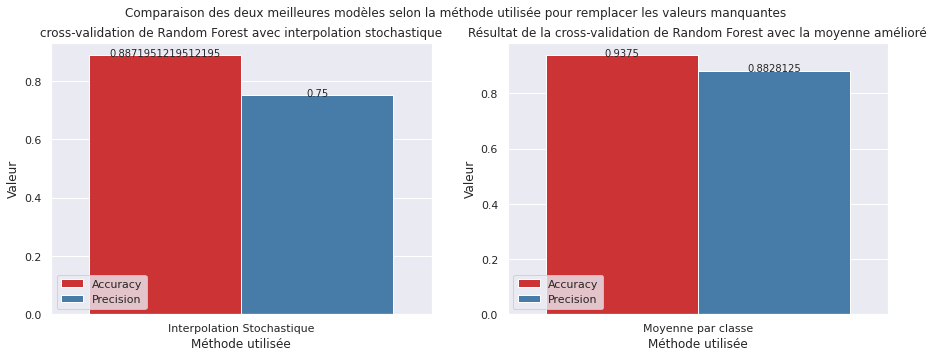

In [ ]:
# On place les resultat dans une dataframe (plus simple pour l'affichage)
df_svm=pd.DataFrame(results_RF_special, columns=["Valeur"])
df_svm["Label"]=["Accuracy", "Precision"]
df_svm["Méthode utilisée"]=["Interpolation Stochastique", "Interpolation Stochastique"]

# On place les resultat dans une dataframe (plus simple pour l'affichage)
df_svm2=pd.DataFrame(results_RF_special2, columns=["Valeur"])
df_svm2["Label"]=["Accuracy", "Precision"]
df_svm2["Méthode utilisée"]=["Moyenne par classe", "Moyenne par classe"]

fig, axes = plt.subplots(1, 2, figsize = (15,5))
fig.suptitle("Comparaison des deux meilleures modèles selon la méthode utilisée pour remplacer les valeurs manquantes")

# On plot la précision et l'accuracy du svm selon la méthode
bar_svm_result=sns.barplot(data = df_svm, x="Méthode utilisée", y="Valeur", hue="Label", ax=axes[0])
add_label_barplot(bar_svm_result)
axes[0].set_title("cross-validation de Random Forest avec interpolation stochastique")
axes[0].legend(loc="lower left")

# On plot la précision et l'accuracy du svm selon la méthode
bar_rf_result=sns.barplot(data = df_svm2, x="Méthode utilisée", y="Valeur", hue="Label", ax=axes[1])
add_label_barplot(bar_rf_result)
axes[1].set_title("Résultat de la cross-validation de Random Forest avec la moyenne amélioré")
axes[1].legend(loc="lower left")

En constate que l'application d'un k-fold entraine une amélioration considérable de plus de 20% au niveau de la précision et la justesse. Le modèle atteint une accuracy extrême de 94% et une précision 85%.

### Expérimentation du RandomForest sur un dataset où les valeurs manquantes sont supprimés

In [ ]:
df=eau_df.dropna()

In [ ]:
X = df.drop(columns='Potability',axis=1)
Y = df['Potability']
#séparation en train et test
X_train,X_test,Y_train,Y_test = train_test_split(X,Y, test_size =0.2, stratify=Y,random_state=0)

In [ ]:
#entrainement de random_forest
from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier()
# On définit les paramètres de notre GridSearch
param_grid = {
    "n_estimators": np.arange(80, 250, 20),
    "max_samples": [0.4, 0.6],
    "max_features": [0.3, 0.5, 0.7, 0.8, 1.0]
}

# On définit puis on entraîne notre GridSearch
gs = GridSearchCV(RF, param_grid, return_train_score=True)
gs.fit(X_train, Y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              ra

Text(0.5, 1.0, 'Accuracy sur le jeu de validation selon le modèle')

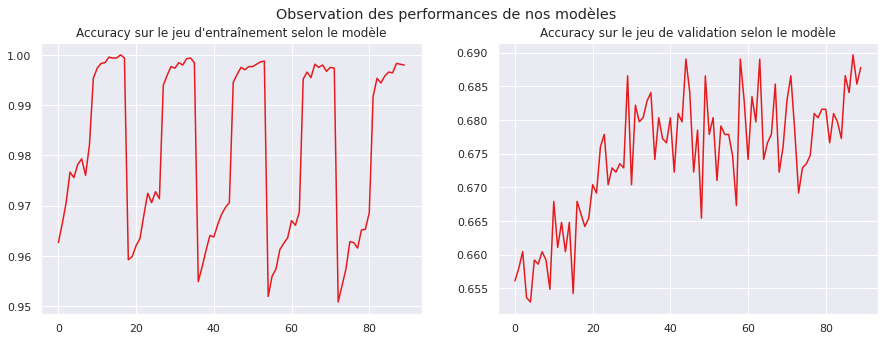

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (15,5))
fig.suptitle("Observation des performances de nos modèles")

sns.lineplot(x=range(len(gs.cv_results_["params"])),y=gs.cv_results_["mean_train_score"], ax=axes[0])
axes[0].set_title("Accuracy sur le jeu d'entraînement selon le modèle")

sns.lineplot(x=range(len(gs.cv_results_["params"])),y=gs.cv_results_["mean_test_score"], ax=axes[1])
axes[1].set_title("Accuracy sur le jeu de validation selon le modèle")

In [ ]:
print("Le meilleur modèle a une accuracy de {0} sur le jeu de test.".format(gs.best_estimator_.score(X_test,Y_test)))

Le meilleur modèle a une accuracy de 0.6898263027295285 sur le jeu de test.


Nous remarquons de bons résultats en passant par le jeu de valeur où nous supprimons les valeurs manquantes en revanche cette solution n'est quand même pas acceptable, car nous ne pouvons pas supprimer nos valeurs manquantes ( elles sont trop nombreuses) sans biaiser les données.

### Expérimentation de Random Forest sur les jeux de données obtenu par interpolation linéaire et polynomiale

Essayons maintenant d'entrainer un algorithme de Random Forest sur les différents 
jeux de données afin de confirmer nos choix.

#### Utilisation de random Forest sur le jeu par interpolation linéaire

In [ ]:
#on supprime la derniére valeur null
eau_df_linear.drop(0,0,inplace=True)


X = eau_df_linear.drop(columns='Potability',axis=1)
Y = eau_df_linear['Potability']

In [ ]:
#séparation en train et test
from sklearn.model_selection import train_test_split

X_train,X_test,Y_train,Y_test = train_test_split(X,Y, test_size =0.2, stratify=Y,random_state=0)

In [ ]:
#entrainement de random_forest
from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier()
# On définit les paramètres de notre GridSearch
param_grid = {
    "n_estimators": np.arange(100, 301, 50),
    "max_samples": np.arange(0.3, 0.6, 0.1),
    "max_features": [0.2, 0.4, 0.6]
}

# On définit puis on entraîne notre GridSearch
gs = GridSearchCV(RF, param_grid, return_train_score=True)
gs.fit(X_train, Y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              ra

Text(0.5, 1.0, 'Accuracy sur le jeu de validation selon le modèle')

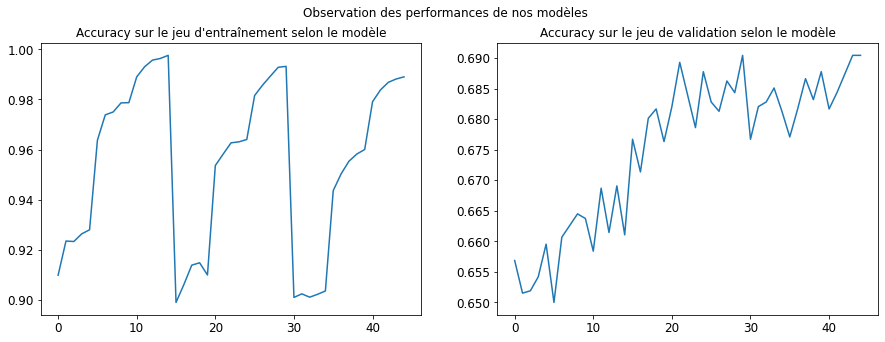

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (15,5))
fig.suptitle("Observation des performances de nos modèles")

sns.lineplot(x=range(len(gs.cv_results_["params"])),y=gs.cv_results_["mean_train_score"], ax=axes[0])
axes[0].set_title("Accuracy sur le jeu d'entraînement selon le modèle")

sns.lineplot(x=range(len(gs.cv_results_["params"])),y=gs.cv_results_["mean_test_score"], ax=axes[1])
axes[1].set_title("Accuracy sur le jeu de validation selon le modèle")

In [ ]:
print("Le meilleur modèle a une accuracy de {0} sur le jeu de test.".format(gs.best_estimator_.score(X_test,Y_test)))

Le meilleur modèle a une accuracy de 0.6335877862595419 sur le jeu de test.


#### Utilisation de random Forest sur le jeu par interpolation Polynomial

In [ ]:
#on supprime la derniére valeur null
index_with_nan = eau_df_polynomial.index[eau_df_polynomial.isnull().any(axis=1)]

eau_df_polynomial.drop(index_with_nan,0,inplace=True)


X = eau_df_polynomial.drop(columns='Potability',axis=1)
Y = eau_df_polynomial['Potability']

In [ ]:
#séparation en train et test
X_train,X_test,Y_train,Y_test = train_test_split(X,Y, test_size =0.2, stratify=Y,random_state=0)

In [ ]:
#entrainement de random_forest
from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier()
# On définit les paramètres de notre GridSearch
param_grid = {
    "n_estimators": np.arange(100, 301, 50),
    "max_samples": np.arange(0.3, 0.6, 0.1),
    "max_features": [0.2, 0.4, 0.6]
}

# On définit puis on entraîne notre GridSearch
gs = GridSearchCV(RF, param_grid, return_train_score=True)
gs.fit(X_train, Y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              ra

Text(0.5, 1.0, 'Accuracy sur le jeu de validation selon le modèle')

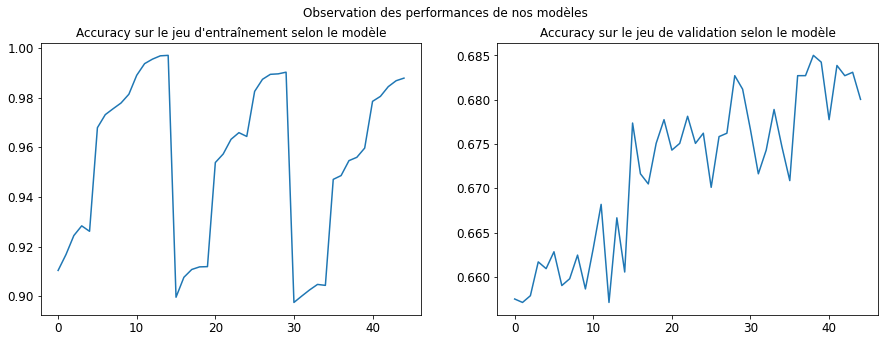

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (15,5))
fig.suptitle("Observation des performances de nos modèles")

sns.lineplot(x=range(len(gs.cv_results_["params"])),y=gs.cv_results_["mean_train_score"], ax=axes[0])
axes[0].set_title("Accuracy sur le jeu d'entraînement selon le modèle")

sns.lineplot(x=range(len(gs.cv_results_["params"])),y=gs.cv_results_["mean_test_score"], ax=axes[1])
axes[1].set_title("Accuracy sur le jeu de validation selon le modèle")

In [ ]:
print("Le meilleur modèle a une accuracy de {0} sur le jeu de test.".format(gs.best_estimator_.score(X_test,Y_test)))

Le meilleur modèle a une accuracy de 0.6183206106870229 sur le jeu de test.


Les 2 interpolation polynomial sont mauvaises et offrent de moins bon score que l'imputation par régression stochastique. Cela nous conforte dans notre choix de ne pas sélectionner ces méthodes.

## **Reduction de dimension**

Nous allons utiliser la methode PCA vu en cours 

In [ ]:
from sklearn.preprocessing import scale 
from sklearn.decomposition import PCA

pca = PCA(n_components=8)
X_reduced = pca.fit_transform(scale(X))
X_reduced.shape

X_=pd.DataFrame(X_reduced)
y=df_iterative_imputer["Potability"]

X_train, X_test, y_train, y_test = train_test_split(X_, y, test_size=0.2, random_state=0)

RF = RandomForestClassifier(max_features= 0.7, max_samples=0.6, n_estimators=200)
#training the model
RF.fit(X_train, Y_train)

#Accuracy of the train data
Y_train_predictionRF=RF.predict(X_train)
training_data_accuracyRF= accuracy_score(Y_train_predictionRF, Y_train)
print('Accuracy score of training data :', training_data_accuracyRF)

#Accuracy of the test data
Y_test_predictionRF=RF.predict(X_test)
test_data_accuracyRF= accuracy_score(Y_test_predictionRF, Y_test)
print('Accuracy score of test data :', test_data_accuracyRF)

Accuracy score of training data : 0.998854961832061
Accuracy score of test data : 0.5823170731707317


On remarque une justesse de 57% bien inferieur a celle obtenu sans l'application du PCA. Ceci rejoint la conclusion de la partie de l'analyse des données, dont laquelle on a constaté une décorrélation entre toutes les données.